# Setup

In [1]:
# Imports
from datasets import load_dataset
from transformers import (
    AutoModelForSequenceClassification,
    BertTokenizer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
    TrainingArguments,
    Trainer,
)
import evaluate
import numpy as np
import torch

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda":
    print("CUDA device name:", torch.cuda.get_device_name(0))

Using device: cuda
CUDA device name: NVIDIA GeForce RTX 4060


## Load Dataset

In [3]:
dataset = load_dataset("stanfordnlp/imdb")

train_validation_dataset = dataset["train"].train_test_split(test_size=0.1, seed=42)
train_dataset = train_validation_dataset["train"]
validation_dataset = train_validation_dataset["test"]
test_dataset = dataset["test"]          

print("Train size:", len(train_dataset))
print("Validation size:", len(validation_dataset))
print("Test size:", len(test_dataset))

Train size: 22500
Validation size: 2500
Test size: 25000


## Preprocessing of the dataset

In [4]:
def encode_datasets(tokenizer):
    def preprocess_datasets(examples):
        return tokenizer(
            examples["text"],
            truncation=True,
            max_length=512,
            padding="longest"
        )
    encoded_train = train_dataset.map(preprocess_datasets, batched=True)
    encoded_validation = validation_dataset.map(preprocess_datasets, batched=True)
    encoded_test = test_dataset.map(preprocess_datasets, batched=True)
    
    encoded_train = encoded_train.remove_columns(["text"])
    encoded_validation = encoded_validation.remove_columns(["text"])
    encoded_test = encoded_test.remove_columns(["text"])
    
    encoded_train = encoded_train.with_format("torch")
    encoded_validation = encoded_validation.with_format("torch")
    encoded_test = encoded_test.with_format("torch")
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    return encoded_train, encoded_validation, encoded_test, data_collator
    

## Evaluation metrics

In [5]:
# Metrics
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}


In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "f1": f1.compute(predictions=preds, references=labels, average="weighted")["f1"],
        "precision": precision.compute(predictions=preds, references=labels)["precision"],
        "recall": recall.compute(predictions=preds, references=labels)["recall"]
    }

# Train and test

## Train

In [7]:
def train_and_test_model(model_name):
    tokenizer = BertTokenizer.from_pretrained(
        model_name
    )
    encoded_train, encoded_validation, encoded_test, data_collator = encode_datasets(tokenizer)
    training_args = TrainingArguments(
        output_dir=f"./{model_name}_output",
        eval_strategy="epoch",  
        save_strategy="epoch",           
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        num_train_epochs=10,
        weight_decay=0.01,
        logging_steps=100,
        logging_first_step=True,
        load_best_model_at_end=True,
        report_to="none"
    )
    
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=2,
        id2label=id2label,
        label2id=label2id,
    )
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=encoded_train, 
        eval_dataset=encoded_validation,
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,  
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )
    trainer.train()
    trainer.save_model(f"{model_name}_model")
    test_results = trainer.evaluate(encoded_test)
    
    print("\n====================")
    print(f"Test Results for {model_name}")
    print("====================")
    for k, v in test_results.items():
        print(f"{k}: {v}")
        
    return trainer, encoded_train, encoded_validation, encoded_test, data_collator

In [8]:
# Model names
model_name_uncased = "bert-base-uncased"
model_name_cased = "bert-base-cased"

In [38]:
train_and_test_model(model_name_cased)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.287100,0.272942,0.919200,0.919199,0.925747,0.912490
2,0.212000,0.359836,0.919600,0.919530,0.948980,0.887828
3,0.104200,0.399747,0.924000,0.923964,0.946444,0.899761



Test Results for bert-base-cased
eval_loss: 0.2434881031513214
eval_accuracy: 0.92196
eval_f1: 0.9219559990274637
eval_precision: 0.9280902524145768
eval_recall: 0.9148
eval_runtime: 411.1125
eval_samples_per_second: 60.811
eval_steps_per_second: 3.802
epoch: 3.0


In [9]:
(trainer_uncased, 
 encoded_train_uncased, 
 encoded_validation_uncased, 
 encoded_test_uncased, 
 data_collator_uncased
 ) = train_and_test_model(model_name_uncased)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.254300,0.263237,0.924000,0.923978,0.942005,0.904535
2,0.174900,0.300888,0.930000,0.929999,0.936290,0.923628
3,0.112200,0.367708,0.934000,0.933999,0.941034,0.926810



Test Results for bert-base-uncased
eval_loss: 0.22767554223537445
eval_accuracy: 0.93384
eval_f1: 0.9338375542125641
eval_precision: 0.9391804340783932
eval_recall: 0.92776
eval_runtime: 411.9745
eval_samples_per_second: 60.683
eval_steps_per_second: 3.794
epoch: 3.0


## Visualize Testing

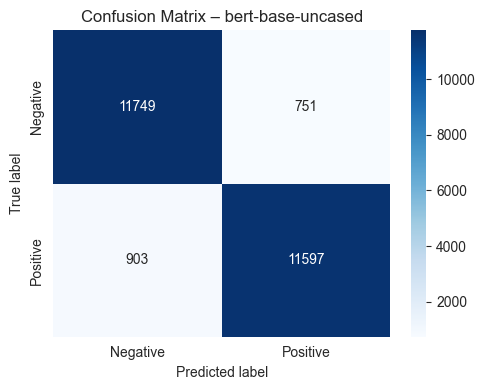

Classification report:
              precision    recall  f1-score   support

    Negative       0.93      0.94      0.93     12500
    Positive       0.94      0.93      0.93     12500

    accuracy                           0.93     25000
   macro avg       0.93      0.93      0.93     25000
weighted avg       0.93      0.93      0.93     25000



In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

label_names = ["Negative", "Positive"]

pred_output = trainer_uncased.predict(encoded_test_uncased)
y_true = pred_output.label_ids
y_pred = np.argmax(pred_output.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title(f"Confusion Matrix – {model_name_uncased}")
plt.tight_layout()
plt.show()

print("Classification report:")
print(classification_report(y_true, y_pred, target_names=label_names))


### Visualisation of worst performing datapoints

In [12]:
import torch
import torch.nn.functional as F

val_outputs = trainer_uncased.predict(encoded_validation_uncased)
val_logits = torch.tensor(val_outputs.predictions)
val_labels = torch.tensor(val_outputs.label_ids)

val_loss_per_example = F.cross_entropy(val_logits, val_labels, reduction="none")

val_loss_per_example = val_loss_per_example.detach().cpu().numpy()


In [19]:
worst_idx = np.argsort(-val_loss_per_example)[:50]

for i in worst_idx[:5]:  
    original_example = validation_dataset[int(i)]
    print("INDEX:", i)
    print("Label:", original_example["label"])
    print("Text:", original_example["text"][:],)
    print("Loss:", val_loss_per_example[i])
    print("-" * 80)

INDEX: 287
Label: 1
Text: I was really excited about seeing this film. I thought finally Australia had made a good film.. but I was wrong.<br /><br />This was the most pathetic attempt at a slasher film ever. I feel sorry for Molly Ringwald having to come all the way to Australia to make an awful movie.<br /><br />The acting was terrible (especially that Australian guy who was trying to speak in an American accent), and the plot was also pretty bad.<br /><br />When I first heard about this film coming out, I thought that the title was pathetic (because it sounds like the cheesy film "Stab" in Scream 2), but I was willing to let it slide if it was a good movie.<br /><br />WARNING!!! MAJOR SPOILERS!!!<br /><br />Probably the worst thing about the film was the ending. I was expecting a big surprise about who the killer was.. but the killer wasn't even human.. which turned this realistic slasher film into an awful horror movie.<br /><br />Don't see this film.. you'll probably be disappoint